In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [2]:
list_of_architectures = [
    "VGG16",
    "VGG19",
    "ResNet101V2",
    "ResNet152V2",
    "InceptionV3",
    "MobileNet",
    "MobileNetV2",
    "DenseNet121",
    "DenseNet169",
    "DenseNet201"
    
]

In [3]:
list_of_classifiers = [
    "SVM"
]

In [4]:
list_of_size = [
    128,
    256
]

In [5]:
layer = "last_layer"

In [6]:
preprocessing_technique = "smote"

In [7]:
output_folder = "output"
analysis_output =  "../" + output_folder + "/" + layer + "_" + preprocessing_technique + "_binary_SVM_128_256.csv"

In [8]:
def getData(model, image_size):
    train_data_dir="../../feature_extractor/" + layer + "/" + str(image_size)+"/"
    test_data_dir="../../feature_extractor/" + layer + "/" + str(image_size)+"/"
    #print(os.listdir(train_data_dir))
    #print(os.listdir(test_data_dir))
    X_train=np.load(train_data_dir+model+"_train_images.npy")
    y_train=np.load(train_data_dir+"train_labels.npy")
    X_test=np.load(test_data_dir+model+"_test_images.npy")
    y_test=np.load(test_data_dir+"test_labels.npy")
    return X_train, y_train, X_test, y_test

In [9]:
def getBinaryData(model, image_size):
    X_train, y_train, X_test, y_test = getData(model, image_size)
    df_train_labels=pd.DataFrame(y_train, columns=["labels"])
    df_test_labels=pd.DataFrame(y_test, columns=["labels"])
    df_train_labels_binary=df_train_labels["labels"].apply(lambda x : 0 if x==11 else 1)
    df_test_labels_binary=df_test_labels["labels"].apply(lambda x : 0 if x==11 else 1)
    y_train_binary = df_train_labels_binary.to_numpy()
    y_test_binary = df_test_labels_binary.to_numpy()
    return X_train, y_train_binary, X_test, y_test_binary

In [10]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        #print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

In [11]:
def getClassificationReport(y_test_binary, prediction):
    test_labels=y_test_binary
    from sklearn import metrics
    balanced_accuracy = round(metrics.balanced_accuracy_score(y_test_binary, prediction),3)
    accuracy = round(metrics.accuracy_score(y_test_binary, prediction),3)
    precision = round(metrics.precision_score(y_test_binary, prediction, average='weighted'),3)
    recall = round(metrics.recall_score(y_test_binary, prediction, average='weighted'),3)
    f1_score = round(metrics.f1_score(y_test_binary, prediction, average='weighted'),3)
    
    
    from sklearn.metrics import confusion_matrix
    test_label_list=list(np.unique(y_test_binary))
    cnf_matrix = confusion_matrix(y_test_binary, prediction,labels=test_label_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(cnf_matrix, classes=test_label_list,
                          title='Confusion matrix, without normalization')

    from sklearn import metrics
    
    accuracy = round(metrics.accuracy_score(test_labels, prediction),3)
    precision = round(metrics.precision_score(test_labels, prediction, average='weighted'),3)
    recall = round(metrics.recall_score(test_labels, prediction, average='weighted'),3)
    f1_score = round(metrics.f1_score(test_labels, prediction, average='weighted'),3)
    
    # Balanced
    balanced_accuracy = round(metrics.balanced_accuracy_score(test_labels, prediction),3)
    
    from sklearn.metrics import confusion_matrix
    TP, FN, FP, TN = confusion_matrix(y_test_binary,prediction,labels=[1,0]).reshape(-1)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round((TP/(TP+FN)),3)
    # Specificity or true negative rate
    TNR = round((TN/(TN+FP) ),3)
    # Precision or positive predictive value
    PPV = round((TP/(TP+FP)),3)
    # Negative predictive value
    NPV = round((TN/(TN+FN)),3)
    # Fall out or false positive rate
    FPR = round((FP/(FP+TN)),3)
    # False negative rate
    FNR = round((FN/(TP+FN)),3)
    # False discovery rate
    FDR = round((FP/(TP+FP)),3)

    # Overall accuracy
    Overall_Acc = round(((TP+TN)/(TP+FP+FN+TN)).mean(),3)
    Bal_F1 = round((2*(PPV*TPR)/(PPV+TPR)),3)
    
    
    print("Acc     = ", accuracy)
    print("Pre     = ", precision)
    print("Rec     = ", recall)
    print("F1      = ", f1_score)
    print("")
    
    print("Bal_Acc = ", balanced_accuracy)
    print("Bal_Pre = ", PPV)
    print("Bal_Rec = ", TPR)
    print("Bal_F1  = ", Bal_F1)
    print("")
    
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(test_labels, prediction))
    
    return accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc


In [12]:
def getSmoteData(X_train, y_train_binary):
    from imblearn.over_sampling import SMOTE
    oversample = SMOTE()
    X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train_binary)
    return X_train_SMOTE, y_train_SMOTE 

In [13]:
def classify(X_train_SMOTE, y_train_SMOTE, X_test, y_test_binary, classifier):
    if classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators = 100, random_state = 42)
    elif classifier == "SVM":
        from sklearn.svm import SVC
        model = SVC(kernel="rbf", degree=3, C=1, decision_function_shape='ovo')
    model.fit(X_train_SMOTE, y_train_SMOTE)
    prediction = model.predict(X_test)
    return prediction

--------------------------------------------------------------------------
SVM VGG16 128

Confusion matrix, without normalization


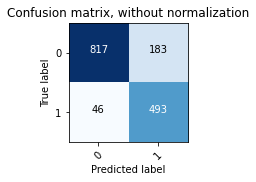

Acc     =  0.851
Pre     =  0.871
Rec     =  0.851
F1      =  0.854

Bal_Acc =  0.866
Bal_Pre =  0.729
Bal_Rec =  0.915
Bal_F1  =  0.811

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1000
           1       0.73      0.91      0.81       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.87      0.85      0.85      1539

--------------------------------------------------------------------------
SVM VGG19 128

Confusion matrix, without normalization


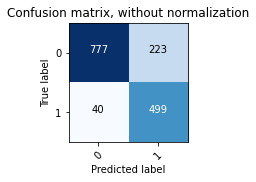

Acc     =  0.829
Pre     =  0.86
Rec     =  0.829
F1      =  0.833

Bal_Acc =  0.851
Bal_Pre =  0.691
Bal_Rec =  0.926
Bal_F1  =  0.791

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1000
           1       0.69      0.93      0.79       539

    accuracy                           0.83      1539
   macro avg       0.82      0.85      0.82      1539
weighted avg       0.86      0.83      0.83      1539

--------------------------------------------------------------------------
SVM ResNet101V2 128

Confusion matrix, without normalization


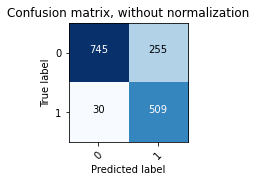

Acc     =  0.815
Pre     =  0.858
Rec     =  0.815
F1      =  0.819

Bal_Acc =  0.845
Bal_Pre =  0.666
Bal_Rec =  0.944
Bal_F1  =  0.781

              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1000
           1       0.67      0.94      0.78       539

    accuracy                           0.81      1539
   macro avg       0.81      0.84      0.81      1539
weighted avg       0.86      0.81      0.82      1539

--------------------------------------------------------------------------
SVM ResNet152V2 128

Confusion matrix, without normalization


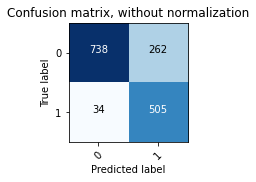

Acc     =  0.808
Pre     =  0.852
Rec     =  0.808
F1      =  0.812

Bal_Acc =  0.837
Bal_Pre =  0.658
Bal_Rec =  0.937
Bal_F1  =  0.773

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      1000
           1       0.66      0.94      0.77       539

    accuracy                           0.81      1539
   macro avg       0.81      0.84      0.80      1539
weighted avg       0.85      0.81      0.81      1539

--------------------------------------------------------------------------
SVM InceptionV3 128

Confusion matrix, without normalization


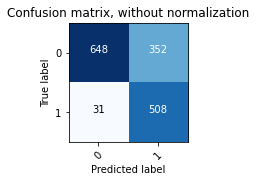

Acc     =  0.751
Pre     =  0.827
Rec     =  0.751
F1      =  0.756

Bal_Acc =  0.795
Bal_Pre =  0.591
Bal_Rec =  0.942
Bal_F1  =  0.726

              precision    recall  f1-score   support

           0       0.95      0.65      0.77      1000
           1       0.59      0.94      0.73       539

    accuracy                           0.75      1539
   macro avg       0.77      0.80      0.75      1539
weighted avg       0.83      0.75      0.76      1539

--------------------------------------------------------------------------
SVM MobileNet 128

Confusion matrix, without normalization


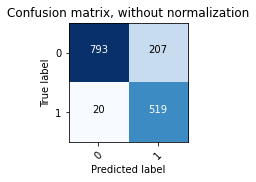

Acc     =  0.853
Pre     =  0.884
Rec     =  0.853
F1      =  0.856

Bal_Acc =  0.878
Bal_Pre =  0.715
Bal_Rec =  0.963
Bal_F1  =  0.821

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1000
           1       0.71      0.96      0.82       539

    accuracy                           0.85      1539
   macro avg       0.85      0.88      0.85      1539
weighted avg       0.88      0.85      0.86      1539

--------------------------------------------------------------------------
SVM MobileNetV2 128

Confusion matrix, without normalization


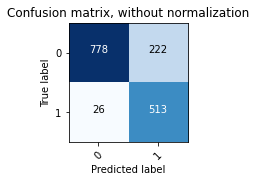

Acc     =  0.839
Pre     =  0.873
Rec     =  0.839
F1      =  0.842

Bal_Acc =  0.865
Bal_Pre =  0.698
Bal_Rec =  0.952
Bal_F1  =  0.805

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1000
           1       0.70      0.95      0.81       539

    accuracy                           0.84      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.84      0.84      1539

--------------------------------------------------------------------------
SVM DenseNet121 128

Confusion matrix, without normalization


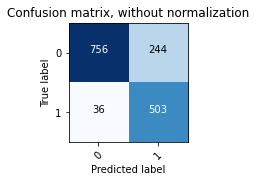

Acc     =  0.818
Pre     =  0.856
Rec     =  0.818
F1      =  0.822

Bal_Acc =  0.845
Bal_Pre =  0.673
Bal_Rec =  0.933
Bal_F1  =  0.782

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      1000
           1       0.67      0.93      0.78       539

    accuracy                           0.82      1539
   macro avg       0.81      0.84      0.81      1539
weighted avg       0.86      0.82      0.82      1539

--------------------------------------------------------------------------
SVM DenseNet169 128

Confusion matrix, without normalization


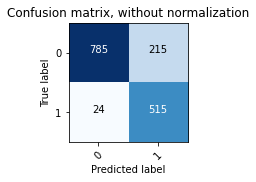

Acc     =  0.845
Pre     =  0.878
Rec     =  0.845
F1      =  0.848

Bal_Acc =  0.87
Bal_Pre =  0.705
Bal_Rec =  0.955
Bal_F1  =  0.811

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1000
           1       0.71      0.96      0.81       539

    accuracy                           0.84      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.84      0.85      1539

--------------------------------------------------------------------------
SVM DenseNet201 128

Confusion matrix, without normalization


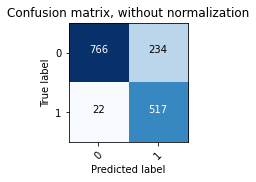

Acc     =  0.834
Pre     =  0.873
Rec     =  0.834
F1      =  0.837

Bal_Acc =  0.863
Bal_Pre =  0.688
Bal_Rec =  0.959
Bal_F1  =  0.801

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1000
           1       0.69      0.96      0.80       539

    accuracy                           0.83      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.83      0.84      1539

--------------------------------------------------------------------------
SVM VGG16 256

Confusion matrix, without normalization


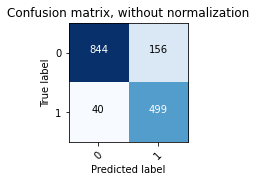

Acc     =  0.873
Pre     =  0.887
Rec     =  0.873
F1      =  0.875

Bal_Acc =  0.885
Bal_Pre =  0.762
Bal_Rec =  0.926
Bal_F1  =  0.836

              precision    recall  f1-score   support

           0       0.95      0.84      0.90      1000
           1       0.76      0.93      0.84       539

    accuracy                           0.87      1539
   macro avg       0.86      0.88      0.87      1539
weighted avg       0.89      0.87      0.87      1539

--------------------------------------------------------------------------
SVM VGG19 256

Confusion matrix, without normalization


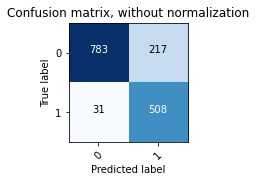

Acc     =  0.839
Pre     =  0.87
Rec     =  0.839
F1      =  0.842

Bal_Acc =  0.863
Bal_Pre =  0.701
Bal_Rec =  0.942
Bal_F1  =  0.804

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.70      0.94      0.80       539

    accuracy                           0.84      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.84      0.84      1539

--------------------------------------------------------------------------
SVM ResNet101V2 256

Confusion matrix, without normalization


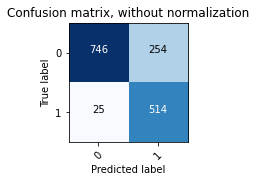

Acc     =  0.819
Pre     =  0.863
Rec     =  0.819
F1      =  0.823

Bal_Acc =  0.85
Bal_Pre =  0.669
Bal_Rec =  0.954
Bal_F1  =  0.786

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      1000
           1       0.67      0.95      0.79       539

    accuracy                           0.82      1539
   macro avg       0.82      0.85      0.81      1539
weighted avg       0.86      0.82      0.82      1539

--------------------------------------------------------------------------
SVM ResNet152V2 256

Confusion matrix, without normalization


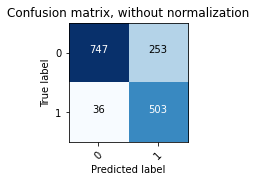

Acc     =  0.812
Pre     =  0.853
Rec     =  0.812
F1      =  0.817

Bal_Acc =  0.84
Bal_Pre =  0.665
Bal_Rec =  0.933
Bal_F1  =  0.777

              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1000
           1       0.67      0.93      0.78       539

    accuracy                           0.81      1539
   macro avg       0.81      0.84      0.81      1539
weighted avg       0.85      0.81      0.82      1539

--------------------------------------------------------------------------
SVM InceptionV3 256

Confusion matrix, without normalization


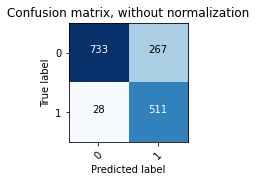

Acc     =  0.808
Pre     =  0.856
Rec     =  0.808
F1      =  0.813

Bal_Acc =  0.841
Bal_Pre =  0.657
Bal_Rec =  0.948
Bal_F1  =  0.776

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1000
           1       0.66      0.95      0.78       539

    accuracy                           0.81      1539
   macro avg       0.81      0.84      0.80      1539
weighted avg       0.86      0.81      0.81      1539

--------------------------------------------------------------------------
SVM MobileNet 256

Confusion matrix, without normalization


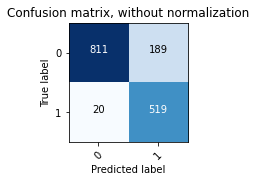

Acc     =  0.864
Pre     =  0.891
Rec     =  0.864
F1      =  0.867

Bal_Acc =  0.887
Bal_Pre =  0.733
Bal_Rec =  0.963
Bal_F1  =  0.832

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1000
           1       0.73      0.96      0.83       539

    accuracy                           0.86      1539
   macro avg       0.85      0.89      0.86      1539
weighted avg       0.89      0.86      0.87      1539

--------------------------------------------------------------------------
SVM MobileNetV2 256

Confusion matrix, without normalization


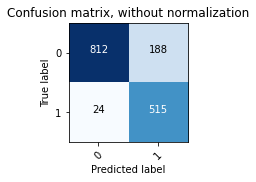

Acc     =  0.862
Pre     =  0.888
Rec     =  0.862
F1      =  0.865

Bal_Acc =  0.884
Bal_Pre =  0.733
Bal_Rec =  0.955
Bal_F1  =  0.829

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1000
           1       0.73      0.96      0.83       539

    accuracy                           0.86      1539
   macro avg       0.85      0.88      0.86      1539
weighted avg       0.89      0.86      0.87      1539

--------------------------------------------------------------------------
SVM DenseNet121 256

Confusion matrix, without normalization


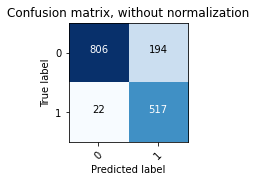

Acc     =  0.86
Pre     =  0.887
Rec     =  0.86
F1      =  0.863

Bal_Acc =  0.883
Bal_Pre =  0.727
Bal_Rec =  0.959
Bal_F1  =  0.827

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1000
           1       0.73      0.96      0.83       539

    accuracy                           0.86      1539
   macro avg       0.85      0.88      0.85      1539
weighted avg       0.89      0.86      0.86      1539

--------------------------------------------------------------------------
SVM DenseNet169 256

Confusion matrix, without normalization


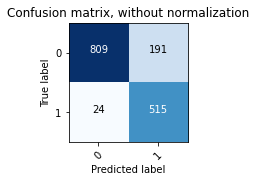

Acc     =  0.86
Pre     =  0.887
Rec     =  0.86
F1      =  0.863

Bal_Acc =  0.882
Bal_Pre =  0.729
Bal_Rec =  0.955
Bal_F1  =  0.827

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1000
           1       0.73      0.96      0.83       539

    accuracy                           0.86      1539
   macro avg       0.85      0.88      0.86      1539
weighted avg       0.89      0.86      0.86      1539

--------------------------------------------------------------------------
SVM DenseNet201 256

Confusion matrix, without normalization


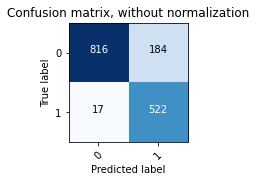

Acc     =  0.869
Pre     =  0.895
Rec     =  0.869
F1      =  0.872

Bal_Acc =  0.892
Bal_Pre =  0.739
Bal_Rec =  0.968
Bal_F1  =  0.838

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1000
           1       0.74      0.97      0.84       539

    accuracy                           0.87      1539
   macro avg       0.86      0.89      0.86      1539
weighted avg       0.90      0.87      0.87      1539



In [14]:
list_of_analysis=[]
for image_size in list_of_size:
    for model in list_of_architectures:
        for classifier in list_of_classifiers:
            print("--------------------------------------------------------------------------")
            print(classifier, model, str(image_size))
            print("")
            X_train, y_train_binary, X_test, y_test_binary = getBinaryData(model, image_size)
            X_train_SMOTE, y_train_SMOTE = getSmoteData(X_train, y_train_binary)
            prediction = classify(X_train_SMOTE, y_train_SMOTE, X_test, y_test_binary, classifier)
            accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc = getClassificationReport(y_test_binary, prediction)
            list_of_analysis.append(
                [
                 classifier, model, image_size, accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc
                ]
            )

In [15]:
list_of_analysis

[['SVM',
  'VGG16',
  128,
  0.851,
  0.871,
  0.851,
  0.854,
  0.866,
  0.729,
  0.915,
  0.811,
  0.817,
  0.947,
  0.183,
  0.085,
  0.271,
  0.851],
 ['SVM',
  'VGG19',
  128,
  0.829,
  0.86,
  0.829,
  0.833,
  0.851,
  0.691,
  0.926,
  0.791,
  0.777,
  0.951,
  0.223,
  0.074,
  0.309,
  0.829],
 ['SVM',
  'ResNet101V2',
  128,
  0.815,
  0.858,
  0.815,
  0.819,
  0.845,
  0.666,
  0.944,
  0.781,
  0.745,
  0.961,
  0.255,
  0.056,
  0.334,
  0.815],
 ['SVM',
  'ResNet152V2',
  128,
  0.808,
  0.852,
  0.808,
  0.812,
  0.837,
  0.658,
  0.937,
  0.773,
  0.738,
  0.956,
  0.262,
  0.063,
  0.342,
  0.808],
 ['SVM',
  'InceptionV3',
  128,
  0.751,
  0.827,
  0.751,
  0.756,
  0.795,
  0.591,
  0.942,
  0.726,
  0.648,
  0.954,
  0.352,
  0.058,
  0.409,
  0.751],
 ['SVM',
  'MobileNet',
  128,
  0.853,
  0.884,
  0.853,
  0.856,
  0.878,
  0.715,
  0.963,
  0.821,
  0.793,
  0.975,
  0.207,
  0.037,
  0.285,
  0.853],
 ['SVM',
  'MobileNetV2',
  128,
  0.839,
  0.873,
  0.

In [16]:
import pandas as pd
df=pd.DataFrame(list_of_analysis, columns=[
                 "classifier",
                 "model",
                 "image_size",
                 "accuracy", 
                 "precision", 
                 "recall", 
                 "f1_score", 
                 "balanced_accuracy", 
                 "balanced_precision_PPV", 
                 "balanced_recall_TPR", 
                 "Bal_F1",
                 "TNR", 
                 "NPV", 
                 "FPR", 
                 "FNR", 
                 "FDR", 
                 "Overall_Acc"
                ])
df

,classifier,model,image_size,accuracy,precision,recall,f1_score,balanced_accuracy,balanced_precision_PPV,balanced_recall_TPR,Bal_F1,TNR,NPV,FPR,FNR,FDR,Overall_Acc
0,SVM,VGG16,128,0.851,0.871,0.851,0.854,0.866,0.729,0.915,0.811,0.817,0.947,0.183,0.085,0.271,0.851
1,SVM,VGG19,128,0.829,0.860,0.829,0.833,0.851,0.691,0.926,0.791,0.777,0.951,0.223,0.074,0.309,0.829
2,SVM,ResNet101V2,128,0.815,0.858,0.815,0.819,0.845,0.666,0.944,0.781,0.745,0.961,0.255,0.056,0.334,0.815
3,SVM,ResNet152V2,128,0.808,0.852,0.808,0.812,0.837,0.658,0.937,0.773,0.738,0.956,0.262,0.063,0.342,0.808
4,SVM,InceptionV3,128,0.751,0.827,0.751,0.756,0.795,0.591,0.942,0.726,0.648,0.954,0.352,0.058,0.409,0.751
5,SVM,MobileNet,128,0.853,0.884,0.853,0.856,0.878,0.715,0.963,0.821,0.793,0.975,0.207,0.037,0.285,0.853
6,SVM,MobileNetV2,128,0.839,0.873,0.839,0.842,0.865,0.698,0.952,0.805,0.778,0.968,0.222,0.048,0.302,0.839
7,SVM,DenseNet121,128,0.818,0.856,0.818,0.822,0.845,0.673,0.933,0.782,0.756,0.955,0.244,0.067,0.327,0.818
8,SVM,DenseNet169,128,0.845,0.878,0.845,0.848,0.870,0.705,0.955,0.811,0.785,0.970,0.215,0.045,0.295,0.845
9,SVM,DenseNet201,128,0.834,0.873,0.834,0.837,0.863,0.688,0.959,0.801,0.766,0.972,0.234,0.041,0.312,0.834


In [17]:
df.to_csv(analysis_output, header=True, index=False)